# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from torchtext.vocab import vocab as torch_vocab

from collections import Counter, OrderedDict
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.

In [6]:
sentences = []
word_threshold = 32

for text in tqdm(dataset['train']['text']):
    sentences.extend(
        [sent.lower() for sent in sent_tokenize(text, language='english')]
    )

#for text in tqdm(dataset['unsupervised']['text']):
#    sentences.extend(
#        [sent.lower() for sent in sent_tokenize(text, language='english')]
#    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 270853


Посчитаем для каждого слова его встречаемость.

In [8]:
words = list()
for sent in tqdm(sentences):
    sent_words = word_tokenize(sent)
    if len(sent_words) < word_threshold:
        words.extend(sent_words)
    
words_counter = Counter(words)

  0%|          | 0/270853 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [9]:
vocab = set()
vocab_size = 40000

special_tokens = ['<unk>', '<pad>', '<eos>', '<bos>']
unk_token = '<unk>'

sorted_by_freq = sorted(words_counter.items(), key=lambda x: x[1], reverse=True)[:vocab_size]
ordered_dict = OrderedDict(sorted_by_freq)
vocab = torch_vocab(ordered_dict, specials=special_tokens)
vocab.set_default_index(vocab[unk_token])

In [10]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [11]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [12]:
word2ind = vocab.get_stoi()
ind2word = {idx: word for word, idx in vocab.get_stoi().items()}

In [13]:
class WordDataset:
    def __init__(self, sentences, vocab):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']
        self.vocab = vocab

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.vocab['<bos>']] + [self.vocab[word] for word in word_tokenize(self.data[idx])] + [self.vocab['<eos>']]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [14]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [15]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.1)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences, vocab)
eval_dataset = WordDataset(eval_sentences, vocab)
test_dataset = WordDataset(test_sentences, vocab)

batch_size = 16

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [55]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1) # N x L x V_size
            loss = criterion(logits, batch['target_ids'].to(device).flatten()) # N x L
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [103]:
def train_model(model, epochs=10):
    criterion = torch.nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    sheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.75)
    losses_train = list()
    ppls_train = list()
    losses_val = list()
    ppls_val = list()
    
    for epoch in range(epochs):
        loss_per_train_epoch = list()
        ppl_per_train_epoch = list()
        loss_per_val_epoch = list()
        ppl_per_val_epoch = list()
        
        model.train()
        with tqdm(train_dataloader, unit="train batch") as tepoch:
            for batch in train_dataloader:
                optim.zero_grad()
                logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1) # N x L x V_size
                loss = criterion(logits, batch['target_ids'].to(device).flatten()) # N x L

                loss.backward()
                optim.step()

                loss_per_train_epoch.append(loss.item())
                ppl_per_train_epoch.append(torch.exp(loss).item())
                
                tepoch.set_description(f"Epoch {epoch + 1}")
                tepoch.set_postfix(loss=loss.item(), ppl=(torch.exp(loss)).item())
                tepoch.update(1)
        
        losses_train.append(np.mean(loss_per_train_epoch))
        ppls_train.append(np.mean(ppl_per_train_epoch))
        
        model.eval()
        with tqdm(eval_dataloader, unit="val batch") as tepoch:
            for batch in eval_dataloader:
                logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1) # N x L x V_size
                loss = criterion(logits, batch['target_ids'].to(device).flatten()) # N x L

                loss_per_val_epoch.append(loss.item())
                ppl_per_val_epoch.append(torch.exp(loss).item())

                tepoch.set_description(f"Epoch {epoch + 1}")
                tepoch.set_postfix(loss=loss.item(), ppl=(torch.exp(loss)).item())
                tepoch.update(1)
            
        losses_val.append(np.mean(loss_per_val_epoch))
        ppls_val.append(np.mean(ppl_per_val_epoch))
        
        sheduler.step()

    return model, losses_val, losses_train, ppls_val, ppls_train

In [106]:
def generate_sequence(model, starting_seq, max_seq_len=12):
    input_ids = [vocab['<bos>']] + [vocab[word.lower()] for word in word_tokenize(starting_seq)]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    input_ids = torch.LongTensor(input_ids).to(device)
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distr = model(input_ids)[-1]
            next_word = next_word_distr.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])
            
            if next_word.item() == vocab['<eos>']:
                break
        
    sent = ' '.join(ind2word[idx.item()] for idx in input_ids)
    
    return sent

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [104]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hid_dim=256):
        super().__init__()

        self.emb = torch.nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=emb_dim
        )
        self.rnn = torch.nn.GRU(
            num_layers=1,
            bias=True,
            input_size=emb_dim,
            hidden_size=hid_dim,
            batch_first=True
        )
        self.lin = torch.nn.Linear(hid_dim, hid_dim, bias=True)
        self.fin = torch.nn.Linear(hid_dim, vocab_size, bias=True)
        self.dropout = nn.Dropout(p=0.05)
        #self.activate = torch.nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embs = self.emb(input_batch)
        output_emb, _ = self.rnn(embs)
        preds = self.fin(self.dropout(self.lin(output_emb)))

        return preds

In [105]:
num_epochs = 5
word_LM = LanguageModel(vocab.__len__()).to(device)
word_LM, losses_val, losses_train, ppls_val, ppls_train = train_model(word_LM, num_epochs)

  0%|          | 0/15236 [00:00<?, ?train batch/s]

  0%|          | 0/8465 [00:00<?, ?val batch/s]

  0%|          | 0/15236 [00:00<?, ?train batch/s]

  0%|          | 0/8465 [00:00<?, ?val batch/s]

  0%|          | 0/15236 [00:00<?, ?train batch/s]

  0%|          | 0/8465 [00:00<?, ?val batch/s]

  0%|          | 0/15236 [00:00<?, ?train batch/s]

  0%|          | 0/8465 [00:00<?, ?val batch/s]

  0%|          | 0/15236 [00:00<?, ?train batch/s]

  0%|          | 0/8465 [00:00<?, ?val batch/s]

In [110]:
generate_sequence(word_LM, 'Hello I', 30)

"<bos> hello i 'm not a fan of the original , but i do n't think it 's a movie that is not only one of the best movies i 've ever seen"

In [112]:
generate_sequence(word_LM, 'what if I', 30)

"<bos> what if i was a little more than a movie that was n't even worth the effort to watch . <eos>"

In [113]:
generate_sequence(word_LM, 'what if', 30)

"<bos> what if you do n't know what is going on ? <eos>"

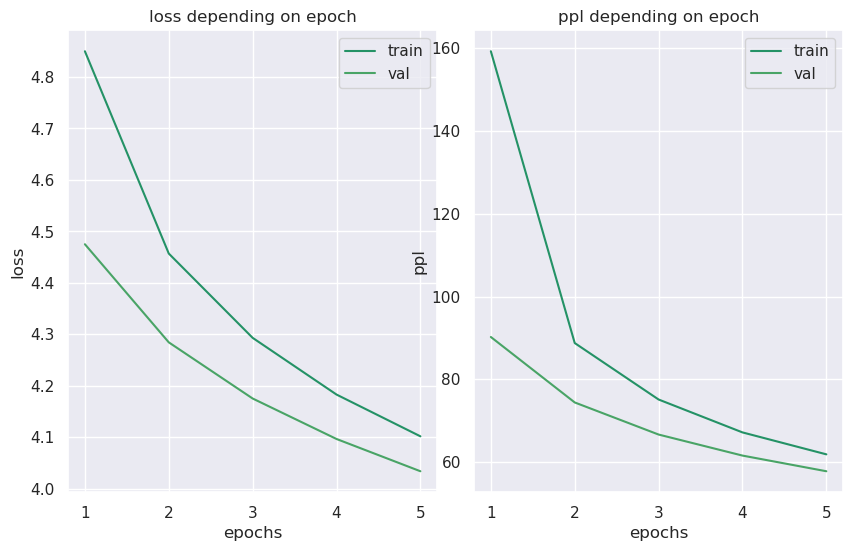

In [154]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
epochs = [i + 1 for i in range(num_epochs)]

axes[0].plot(epochs, losses_train, label='train')
axes[0].plot(epochs, losses_val, label='val')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')
axes[0].set_title('loss depending on epoch')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, ppls_train, label='train')
axes[1].plot(epochs, ppls_val, label='val')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('ppl')
axes[1].set_title('ppl depending on epoch')
axes[1].legend()
axes[1].grid(True)

None

In [126]:
torch.save(word_LM.state_dict(), 'weights_word_LM1.pth')

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [129]:
def train_model_better(model, epochs=10):
    criterion = torch.nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    sheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.8)
    clip_value = 1.0
    losses_train = list()
    ppls_train = list()
    losses_val = list()
    ppls_val = list()
    
    for epoch in range(epochs):
        loss_per_train_epoch = list()
        ppl_per_train_epoch = list()
        loss_per_val_epoch = list()
        ppl_per_val_epoch = list()
        
        model.train()
        with tqdm(train_dataloader, unit="train batch") as tepoch:
            for batch in train_dataloader:
                optim.zero_grad()
                logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1) # N x L x V_size
                loss = criterion(logits, batch['target_ids'].to(device).flatten()) # N x L

                loss.backward()
                torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
                optim.step()

                loss_per_train_epoch.append(loss.item())
                ppl_per_train_epoch.append(torch.exp(loss).item())
                
                tepoch.set_description(f"Epoch {epoch + 1}")
                tepoch.set_postfix(loss=loss.item(), ppl=(torch.exp(loss)).item())
                tepoch.update(1)
        
        losses_train.append(np.mean(loss_per_train_epoch))
        ppls_train.append(np.mean(ppl_per_train_epoch))
        
        model.eval()
        with tqdm(eval_dataloader, unit="val batch") as tepoch:
            for batch in eval_dataloader:
                logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1) # N x L x V_size
                loss = criterion(logits, batch['target_ids'].to(device).flatten()) # N x L

                loss_per_val_epoch.append(loss.item())
                ppl_per_val_epoch.append(torch.exp(loss).item())

                tepoch.set_description(f"Epoch {epoch + 1}")
                tepoch.set_postfix(loss=loss.item(), ppl=(torch.exp(loss)).item())
                tepoch.update(1)
            
        losses_val.append(np.mean(loss_per_val_epoch))
        ppls_val.append(np.mean(ppl_per_val_epoch))
        
        sheduler.step()

    return model, losses_val, losses_train, ppls_val, ppls_train

In [146]:
class LanguageModelBetter(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hid_dim=256):
        super().__init__()

        self.emb = torch.nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=emb_dim
        )
        self.rnn = torch.nn.LSTM(
            num_layers=2,
            input_size=emb_dim,
            hidden_size=hid_dim,
            batch_first=True
        )
        self.lin = torch.nn.Linear(hid_dim, hid_dim * 2)
        self.activate = torch.nn.ReLU()
        self.bn = torch.nn.BatchNorm1d(hid_dim * 2)
        self.fin = torch.nn.Linear(hid_dim * 2, vocab_size)
        self.dropout = nn.Dropout(p=0.05)
        #self.activate = torch.nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embs = self.emb(input_batch)
        output_emb, _ = self.rnn(embs)
        lin_emb = self.lin(output_emb).transpose(1, 2)
        norm_emb = self.bn(lin_emb).transpose(1, 2)
        preds = self.fin(self.dropout(self.activate(norm_emb)))

        return preds

In [148]:
num_epochs = 4
word_LM_Better = LanguageModelBetter(vocab.__len__(), emb_dim=284, hid_dim=184).to(device)
word_LM_Better, losses_val_Better, losses_train_Better, ppls_val_Better, ppls_train_Better = train_model(word_LM_Better, num_epochs)

  0%|          | 0/15236 [00:00<?, ?train batch/s]

  0%|          | 0/8465 [00:00<?, ?val batch/s]

  0%|          | 0/15236 [00:00<?, ?train batch/s]

  0%|          | 0/8465 [00:00<?, ?val batch/s]

  0%|          | 0/15236 [00:00<?, ?train batch/s]

  0%|          | 0/8465 [00:00<?, ?val batch/s]

  0%|          | 0/15236 [00:00<?, ?train batch/s]

  0%|          | 0/8465 [00:00<?, ?val batch/s]

In [149]:
torch.save(word_LM_Better.state_dict(), 'weights_word_LM2.pth')

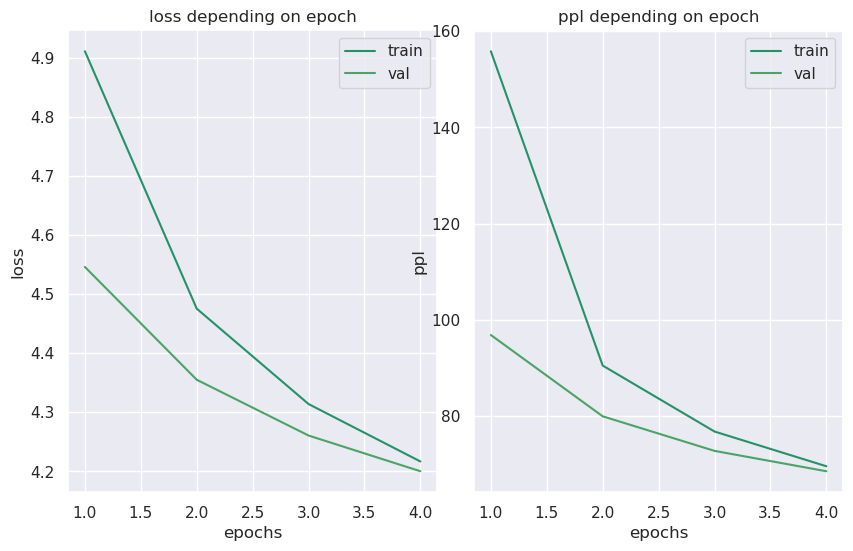

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
epochs = [i + 1 for i in range(num_epochs)]

axes[0].plot(epochs, losses_train_Better, label='train')
axes[0].plot(epochs, losses_val_Better, label='val')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')
axes[0].set_title('loss depending on epoch')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, ppls_train_Better, label='train')
axes[1].plot(epochs, ppls_val_Better, label='val')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('ppl')
axes[1].set_title('ppl depending on epoch')
axes[1].legend()
axes[1].grid(True)

None

In [155]:
generate_sequence(word_LM, 'Hello I', 30)

"<bos> hello i 'm not a fan of the original , but i do n't think it 's a movie that is not only one of the best movies i 've ever seen"

In [156]:
generate_sequence(word_LM, 'How I', 30)

'<bos> how i can watch this movie again and again . <eos>'

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

В целом обе модели (LSTM и GRU) хорошо справились с задачей языкового моделирования